# Tutorial

## Import the necessary Packages

In [2]:
# used in the previous experiments
from datasets import load_dataset, load_from_disk
from transformers import AutoTokenizer

# for training
from transformers import DataCollatorForLanguageModeling
from transformers import GPT2Config, GPT2LMHeadModel
from transformers import TrainingArguments, Trainer

# for experiment tracking
import wandb


# common packages
import pandas as pd
from pprint import pprint
import json
import numpy as np
from matplotlib import pyplot as plt

In [3]:
ds_full = load_dataset('bookcorpus', split='all')
pprint(ds_full)

KeyboardInterrupt: 

## Distribution of the length of the samples

In [ ]:
# Calculate the length of each sample (number of words per sample)
sample_lengths = [len(text.split()) for text in ds_full['text']]
sample_lengths.sort()

In [ ]:
bins = np.unique(sample_lengths)

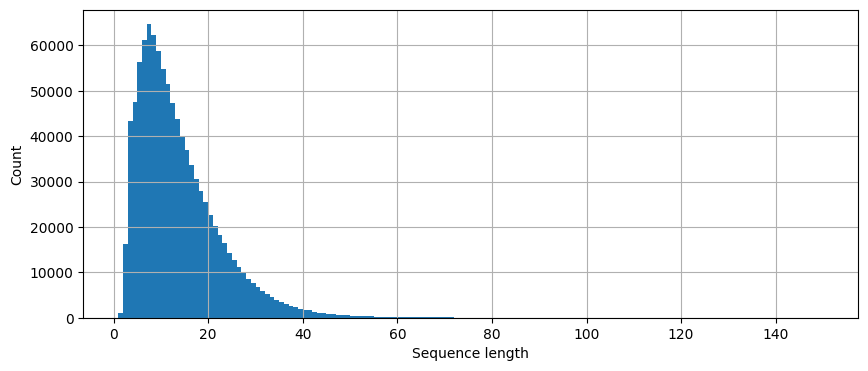

In [ ]:
# Plot the distribution
import random
plt.figure(figsize=(10, 4))
plt.hist(random.sample(sample_lengths, k=10**6), bins=bins[0:150])
plt.xlabel('Sequence length')
plt.ylabel('Count')
plt.grid()
plt.show()

## Tokenization from the previous week

In [ ]:
# hopper_tokenizer = AutoTokenizer.from_pretrained('../week-2/hopper')
# hopper_tokenizer
auto_loaded_tokenizer = AutoTokenizer.from_pretrained(
    "../week-2/awesome_tokenizer", 
    local_files_only=True
)

In [ ]:
hopper_tokenizer = AutoTokenizer.from_pretrained(
    "../week-2/awesome_tokenizer", 
    local_files_only=True
)
hopper_tokenizer

PreTrainedTokenizerFast(name_or_path='../week-2/awesome_tokenizer', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'pad_token': '[PAD]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

## Apply for batch samples

In [ ]:
bs =4 # batch_size
model_inputs = hopper_tokenizer(ds_full[0:bs]['text'], padding=True)
pprint(model_inputs['input_ids'], compact=True)

[[2462, 19, 149, 277, 162, 6456, 422, 131, 1559, 536, 19, 2301, 201, 177, 9774,
  21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0],
 [212, 297, 289, 456, 208, 46, 20830, 1420, 214, 4099, 1171, 139, 11126, 21, 0,
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0],
 [178, 206, 337, 7656, 14, 64, 1147, 303, 174, 503, 214, 2363, 2310, 21, 0, 0,
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0],
 [149, 14, 49, 946, 131, 3760, 880, 375, 3446, 19, 3766, 149, 166, 46, 545,
  1185, 200, 131, 61, 90, 17794, 19, 212, 201, 2596, 9302, 19, 1050, 201, 163,
  3186, 19, 5696, 166, 2270, 5194, 138, 717, 178, 278, 2596, 21]]


## Instead of the hopper tokenizer, use gpt2

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')
print(tokenizer)

c:\Users\smlab\.conda\envs\dlpenv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\smlab\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


GPT2TokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
)


> The parameter `padding_side` is set to `right`, but since no padding token is used, we should add a padding token to avoid errors from HF

In [ ]:
tokenizer.pad_token = '<|endoftext|>'

## Map Function

### Custom mapping function

> Which takes a batch of samples and returns `input_ids` and `attention_mask` such that the length of `input_ids` is 1024 for all samples.

### Apply Encoding

> Define a mapping function that takes a batch of samplews and returns input_ids and attention_mask such that the length of input_ids is 1024 for all samples.

In [ ]:
tokenizer

GPT2TokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
)

In [ ]:
def cust_func(batch_size):
  return tokenizer(
    batch_size['text'],
    padding = 'max_length',
    truncation = True,
    max_length = 1024,
    return_attention_mask=True
      )

## Apply the mapping to your dataset

In [ ]:
tokenized_ds = ds_full.map(
  cust_func,
  batched=True,
  remove_columns=ds_full.column_names # removes original text
)

In [ ]:
ds_chunked = load_from_disk('')